In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn import metrics

In [2]:
class ChessData(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path, index_col=0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        inputs = row[:321].values.astype(np.float32)
        outputs = row[321:].values.astype(np.float32)

        return {'board': inputs, 'themes': outputs}


In [3]:
from torch.utils.data import DataLoader

batch_size = 256

chess_data_set = ChessData('cleaned_data/cleaned_train_puzzles.csv')

train_dataloader = DataLoader(chess_data_set, batch_size=batch_size, num_workers=4, persistent_workers=True, shuffle=True)

In [4]:
chess_validation_set = ChessData('cleaned_data/cleaned_validation_puzzles.csv')

validation_dataloader = DataLoader(chess_validation_set, batch_size=batch_size, num_workers=4, persistent_workers=True)

In [5]:
import torch.nn as nn

net = nn.Sequential(
    nn.Linear(321, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 28),
)


In [6]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.BCEWithLogitsLoss()

In [7]:
def get_validation_loss():
    net.eval()
    total_loss = 0
    num_batches = 0

    for batch in tqdm(validation_dataloader):
        X = batch['board'].cuda()

        with torch.no_grad():
            pred = net(X)

        loss = loss_fn(pred, batch['themes'].cuda())
        total_loss += loss

        num_batches += 1

    total_loss /= num_batches

    return total_loss

In [8]:
net = net.cuda()
net.train()
loss_list = []
accuracy_list = []

for epoch in tqdm(range(11)):
    epoch_correct_predictions = 0
    epoch_train_loss = 0
    num_batches = 0

    for batch in train_dataloader:
        X = batch['board'].cuda()
        pred = net(X)

        # Batch loss
        loss = loss_fn(pred, batch['themes'].cuda())
        epoch_train_loss += loss

        # Batch accuracy
        boolean_pred = (pred>0).float()
        epoch_correct_predictions += (boolean_pred == batch['themes'].cuda()).float().sum()

        optim.zero_grad()
        loss.backward()
        optim.step()
        num_batches += 1

    # Loss
    epoch_train_loss /= num_batches
    epoch_val_loss = get_validation_loss()

    loss_list.append((epoch_train_loss.item(), epoch_val_loss.item()))

    # Accuracy
    epoch_accuracy = epoch_correct_predictions.item()/(len(train_dataloader.dataset) * 28)
    accuracy_list.append(epoch_accuracy)

    if epoch % 10 == 0:
        torch.save(net.state_dict(), f"model-epoch-{epoch}.pth")

torch.save(net.state_dict(), f"model-final-state.pth")


220/607 [00:05<00:09, 39.61it/s]
100%|██████████| 11/11 [11:11<00:00, 61.05s/it]


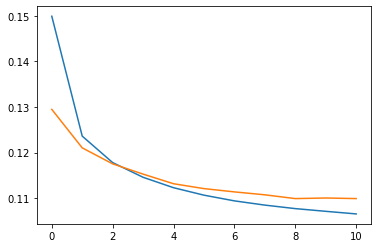

In [9]:
train_line = [loss[0] for loss in loss_list]
validation_line = [loss[1] for loss in loss_list]

plt.plot(train_line, label="train")
plt.plot(validation_line, label="validation")

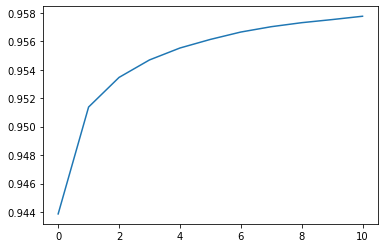

In [10]:
plt.plot(accuracy_list, label="accuracy")